In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [62]:
# Parameters

dataset = 'SFHH'
beta = 0.6
Delta_T = 500
k = 5
phi = 0.5

In [63]:
# Construct Graph

src, dst, ts = [], [], []
G = nx.Graph()

with open(f'../data/{dataset}.txt', 'r') as f:
    for line in f:
        line = list(map(int, line.strip().split('\t')))
        src.append(line[0])
        dst.append(line[1])
        ts.append(line[2])
        G.add_node(line[0], is_infected=False)
        G.add_node(line[1], is_infected=False)
        G.add_edge(line[0], line[1], timestamp=line[2])

src, dst, ts = np.array(src), np.array(dst), np.array(ts) # ts is given sorted
len(G.nodes)

403

In [64]:
# Calculate node influences

rng = np.random.RandomState(1)

node_influences = []

# for each node in the graph
for node in G.nodes:
    # pick a random t_0 and infect the node
    if not np.any(src == node):
        node_influences.append(0)
        continue
    t_0 = np.min(ts[src == node])
    G.nodes[node]['is_infected'] = True

    # for every timestep in (t_0, t_0 + Delta_T)
    for t in range(t_0 + 1, t_0 + Delta_T):
        # if off bounds, continue
        if t not in ts:
            continue
        # for every node in the graph
        for n, nbrs in G.adj.items():
            # if the node is infected
            if G.nodes[n]['is_infected']:
                # get its neighbors at that timestamp
                for nbr, eattr in nbrs.items():
                    if eattr['timestamp'] == t:
                        # infect them with probability b
                        G.nodes[nbr]['is_infected'] = True if rng.uniform() <= beta else False

    # node influence
    node_influences.append(len([n for n in G.nodes if G.nodes[n]['is_infected']]) / len(G.nodes))

    # reset graph
    for n in G.nodes:
        G.nodes[n]['is_infected'] = False

node_influences = np.array(node_influences)

In [ ]:
# Construct subgraphs and calculate subgraph-related metrics

####### labels #######
labels = [
    'Number of union of contacts in [t_0, t_0 + Delta_T]',
    'Closeness Centrality',
    'Wiener Indices',
    'Betweenness Centrality',
    'Subgraph Centrality',
    'VoteRank',
    'Degree',
    'Degree Assortativity Coefficient',
    'Harmonic Centrality',
    'Local Reaching Centrality',
    # 'Eigenvector Centrality'
]

metrics = [[] for _ in labels]
for node in G.nodes:
    if not np.any(src == node):
        for i in range(len(metrics)):
            metrics[i].append(0)
        continue
    # get the index of the first time that node appears
    start_idx = np.min(np.arange(len(src))[src == node])
    t_0 = ts[start_idx]

    subgraph = nx.Graph()  # subgraph in (t_0, t_0 + Delta_T)
    for t in range(start_idx, start_idx + int(phi * Delta_T)):
        if t < len(src):
            subgraph.add_edge(src[t], dst[t])

    ####### metrics #######
    metrics[0].append(len(nx.single_source_shortest_path(subgraph, node, cutoff=k)))
    metrics[1].append(nx.closeness_centrality(subgraph, node))
    metrics[2].append(nx.wiener_index(subgraph))
    metrics[3].append(nx.betweenness_centrality(subgraph)[node])
    metrics[4].append(nx.subgraph_centrality(subgraph)[node])
    metrics[5].append(np.argmax(nx.voterank(subgraph)))
    metrics[6].append(subgraph.degree[node])
    metrics[7].append(nx.degree_assortativity_coefficient(subgraph))
    metrics[8].append(nx.harmonic_centrality(subgraph)[node])
    metrics[9].append(nx.local_reaching_centrality(subgraph, node))
    # metrics[10].append(nx.eigenvector_centrality(subgraph)[node])

for i, m in enumerate(metrics):
    m = np.array(m)
    m = np.abs(m)
    ma = np.max(m[m != np.inf])
    m = m / ma # scale it to 0-1
    m[m == np.inf] = 1
    metrics[i] = m

In [66]:
# Calculate MSEs

y = node_influences
mse = []
for m in metrics:
    mse.append((np.sum(m - y)**2) / len(y))
list(zip(labels, mse))

[('Number of union of contacts in [t_0, t_0 + Delta_T]', 0.013811630040977163),
 ('Closeness Centrality', 2.773912800660302),
 ('Wiener Indices', nan),
 ('Betweenness Centrality', 17.068892980978966),
 ('Subgraph Centrality', 13.498385758902144),
 ('VoteRank', 3.153195823719351),
 ('Degree', 0.5781670486659983),
 ('Degree Assortativity Coefficient', 20.244574460858267),
 ('Harmonic Centrality', 0.359693701779897),
 ('Local Reaching Centrality', 2.864878292642017)]

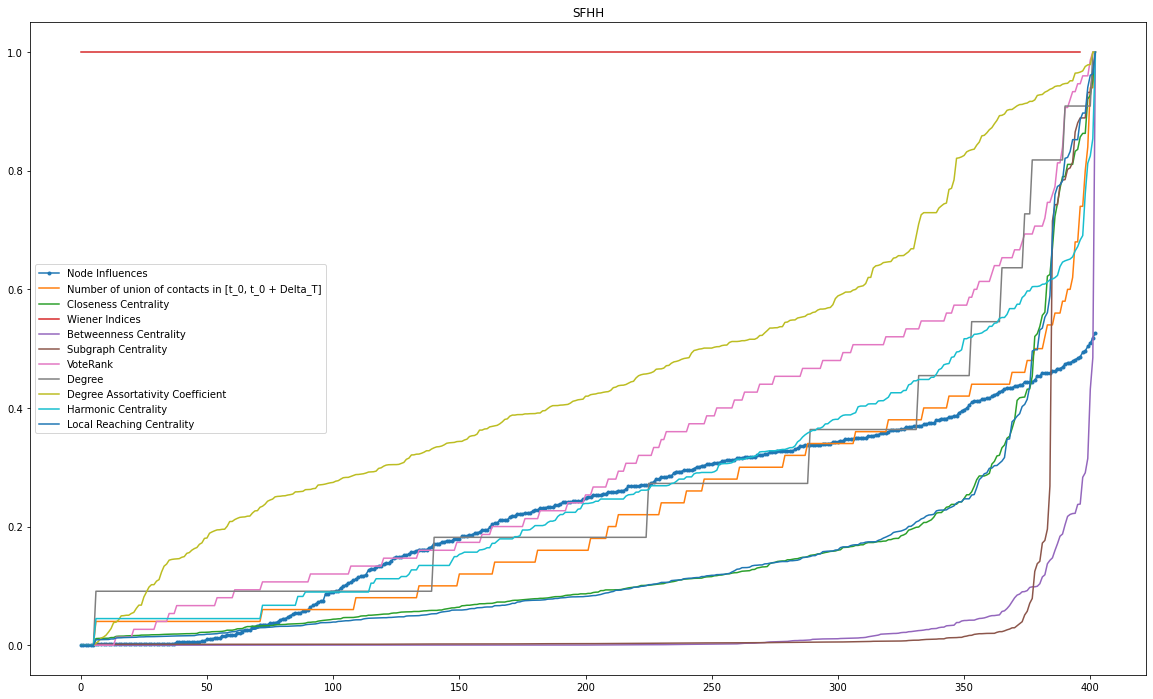

In [67]:
# Plot

# sort to compare cumulatively
sort = True

x = np.arange(len(node_influences))

plot_metrics = metrics.copy()

y = np.sort(node_influences) if sort else node_influences
for i, m in enumerate(metrics):
    plot_metrics[i] = np.sort(m) if sort else m

fig, ax1 = plt.subplots(figsize=(20, 12))
ax1.plot(x, y, '.-', label='Node Influences')
for i, m in enumerate(plot_metrics):
    ax1.plot(x, m, label=labels[i])
plt.title(dataset)
plt.legend()
plt.savefig(f'{dataset}{"-cumulative" if sort else ""}.png')

Conclusions

Useful metrics that seem to model closely to the node influences, apart from Num. of union of contacts:

|dataset      | n_nodes | n_edges | beta |Delta_T|duration|k    |phi  |best metrics|
| ----------- |-------- | ------- | ---- | ----- | ------ | --- | --- | ---------- |
| ht09        |  113    |  20818  | 0.8  | 1000  | 27s    | 5   | 0.5 | Closeness Centrality, Degree Assortativity Coefficient     |
| infectious  |     410 |  17298  | 0.6  | 500   | 67s    | 5   | 0.5 | Eigenvalue Centrality does not converge, so removed. Betweeness/Subgraph centrality. |
| SFHH        |     403 | 70261   | 0.6  | 500   |  180s  | 5   | 0.5 | Eigen. not converging, removed. Num of union of contacts, Degree, Harmonic/Local-Reaching Centralities. |    
| tij_lnVS15  |   217   | 78249   | 0.6  | 500   |  21s   | 5   | 0.5 | Eigen. again not conv., removed. Betweeness/Subgraph centralities |
